In [146]:
from itertools import product
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline

In [23]:
from data import read_dataset, preprocess_features

In [163]:
X_train, y_train, X_test, y_test = read_dataset("data/6.txt")

In [164]:
X_train, X_test = preprocess_features(X_train, X_test)

## Метрика

$$ NRMSE = \frac{\sqrt{\mathbb{E}((\hat{y} - y)^2)}}{y_{max} - y_{min}}$$

In [165]:
def nrmse(X_test, y_test, weights):
    y_max = np.max(y_test)
    y_min = np.min(y_test)
    y_hat = X_test @ weights
    
    rmse = np.sqrt(np.mean((y_hat - y_test) ** 2))
    nrmse = rmse / (y_max - y_min)
    
    return nrmse

## Метод наименьших квадратов
$w = (X^TX + \lambda I)^{-1} X^T y$

In [219]:
def least_squares(X, y, lambd=0.0):
    """ Least Squares solution with L2 reg 
    Computes the pseudo-inverse of a matrix """
    inv = np.linalg.inv(X.T @ X + lambd * np.eye(X.shape[1]))
    pinv = inv @ X.T    
    weights = pinv @ y
    
    return weights

In [220]:
def grid_search_lstsq(lambdas):
    best_test_metric = 99999
    best_val = None

    for l2_reg in tqdm(lambdas): 
        w = least_squares(X_train, y_train, l2_reg)
        metric = nrmse(X_test, y_test, w)

        if metric < best_test_metric:
            best_test_metric = metric
            best_val = l2_reg
            
    print(f'Best NRMSE: {best_test_metric}, lambda: {best_val}')

In [223]:
grid_search_lstsq([l / 1000 for l in range(1, 5000)])


Best NRMSE: 3.597943944860543e-05, lambda: 0.001


## Cosine Annealing

In [224]:
def cosine_decay(base_lr, cur_idx, num_iters, min_lr=.0):
    return min_lr + 0.5 * (base_lr - min_lr) * (1 + np.cos(math.pi * cur_idx / num_iters))

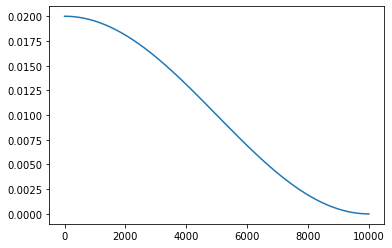

In [225]:
plt.plot([cosine_decay(0.02, i, 10000) for i in range(10000)])
plt.show()

## Стохастический градиентный спуск

$$\hat{y} = w X + b$$

добавляя единичку в конец признаков X:   

$$\hat{y} = w X$$

$$\frac{\partial \hat{y}}{\partial w} = X$$

$$L = (y - \hat{y})^2 + \lambda {\lVert \mathbf{w} \rVert}^2$$

$$\frac{\partial L}{\partial \hat{y}} = 2 (\hat{y} - y)$$

$$\frac{\partial L}{\partial w} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial w} = 2 ((\hat{y} - y) X + \lambda w)$$

In [226]:
def stochastic_gradient(X_i, y_i, weights, lambda_reg):
    y_hat = X_i @ weights
    grad = 2 * ((y_hat - y_i) * X_i + lambda_reg * weights)
    
    return grad


def sgd(X_train, y_train, lambd=0.0, learning_rate=0.01, visualize=True, num_iters=2000):
    """ Stochastic Gradient Descent of Linear Regression 
    with L2 Reg, Loss EMA, Cosine LR Decay """
    n = X_train.shape[0]
    k = X_train.shape[1]
    
    # Uniform initilization
    weights = np.random.uniform(low=-1/(2 * n), high=1/(2 * n), size=k)
    
    losses = list()
    
    for iter_idx in range(num_iters):
        sample_idx = np.random.randint(n)
        
        y_hat = X_train[sample_idx] @ weights
        l2_loss = (y_hat - y_train[sample_idx]) ** 2
        losses.append(l2_loss)
        
        weights -= cosine_decay(
            learning_rate, iter_idx, num_iters) * stochastic_gradient(
            X_train[sample_idx], y_train[sample_idx], weights, lambd)
    
    if visualize:
        plt.title("L2 Loss")
        plt.plot(losses)
        plt.show
    
    return weights

In [227]:
def grid_search_sgd(lambdas, learning_rates):
    configs = list(product(lambdas, learning_rates))

    best_config = None
    best_test_metric = 999999

    for config in tqdm(configs):
        weights = sgd(X_train, y_train, config[0], config[1], False)
        metric = nrmse(X_test, y_test, weights)

        if metric < best_test_metric:
            best_test_metric = metric
            best_config = config
            
    print(f"Best Test NRMSE {best_test_metric}, lr: {best_config[1]}, lambda {best_config[0]}")
    
    return best_config

In [228]:
best_config = grid_search_sgd(
    [0.00, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 0.5],
    [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2, 5e-1, 1e-1]
)

/home/seva/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
/home/seva/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/seva/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in matmul
/home/seva/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in matmul
  
/home/seva/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/home/seva/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in matmul
/home/seva/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarni


Best Test NRMSE 0.05454415306058168, lr: 0.001, lambda 0.001


0.05551277085501627

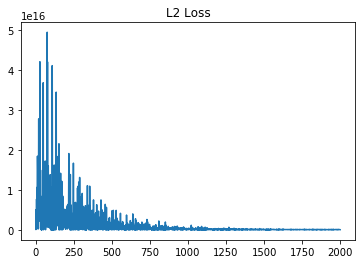

In [229]:
weights = sgd(X_train, y_train, best_config[0], best_config[1], True)
nrmse(X_test, y_test, weights)

In [230]:
def epoched_sgd(X_train, y_train, lambd=0.0, learning_rate=0.01, check_every_k=10, num_iters=2000):
    """ Stochastic Gradient Descent of Linear Regression 
    with L2 Reg, Loss EMA, Cosine LR Decay """
    n = X_train.shape[0]
    k = X_train.shape[1]
    
    # Uniform initilization
    weights = np.random.uniform(low=-1/(2 * n), high=1/(2 * n), size=k)
    
    train_scores = list()
    test_scores = list()
    
    for iter_idx in range(num_iters):
        sample_idx = np.random.randint(n)
                
        weights -= cosine_decay(
            learning_rate, iter_idx, num_iters) * stochastic_gradient(
            X_train[sample_idx], y_train[sample_idx], weights, lambd)
        
        if iter_idx % check_every_k == 0:
            train_scores.append(nrmse(X_train, y_train, weights))
            test_scores.append(nrmse(X_test, y_test, weights))
        
    
    return weights, train_scores, test_scores

In [231]:
w, train_scores, test_scores = epoched_sgd(X_train, y_train, best_config[0], best_config[1])

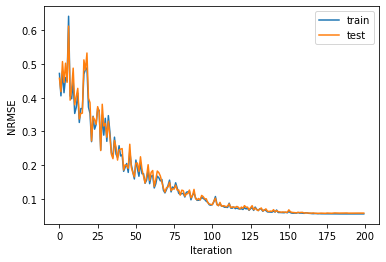

In [232]:
plt.plot(train_scores, label="train")
plt.plot(test_scores, label="test")
plt.xlabel("Iteration")
plt.ylabel("NRMSE")
plt.legend()

plt.show()

## Датасет 2

In [234]:
X_train, y_train, X_test, y_test = read_dataset("data/2.txt")
X_train, X_test = preprocess_features(X_train, X_test)

In [235]:
grid_search_lstsq([l / 1000 for l in range(1, 5000)])


Best NRMSE: 2.649530130966039e-06, lambda: 0.01


In [236]:
best_config = grid_search_sgd(
    [0.00, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 0.5],
    [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2, 5e-1, 1e-1]
)

/home/seva/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
/home/seva/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/home/seva/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in matmul
/home/seva/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in matmul
  
/home/seva/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/home/seva/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in matmul
/home/seva/anaco


Best Test NRMSE 4.939432470442497e-06, lr: 0.01, lambda 1e-05


6.229818124506692e-06

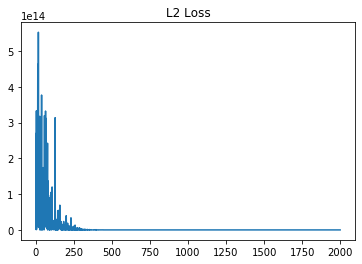

In [237]:
weights = sgd(X_train, y_train, best_config[0], best_config[1], True)
nrmse(X_test, y_test, weights)

In [238]:
w, train_scores, test_scores = epoched_sgd(X_train, y_train, best_config[0], best_config[1])

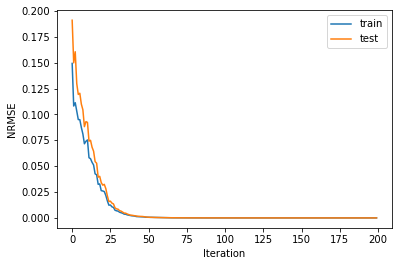

In [239]:
plt.plot(train_scores, label="train")
plt.plot(test_scores, label="test")
plt.xlabel("Iteration")
plt.ylabel("NRMSE")
plt.legend()

plt.show()